# Results
This notebook contains some analysis performed using the catalogue of RNe observed in the CrA star forming region using the OmegaCAM data.

#### prepare the notebook

In [44]:
#imports
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
from astropy.table import Table

In [45]:
#run only if you want to save the images
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 15,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [52]:
#opening catalogues of yso
yso = pd.read_csv('../YSO/catalogues/merged_complete.csv')
dunhmart = pd.read_csv('../YSO/catalogues/Marton+Dunham.csv', index_col=0)
ppvii = pd.read_csv('../YSO/catalogues/pp7_cata.tsv', delimiter='\t')
esplin = pd.DataFrame(np.array(Table.read('../YSO/catalogues/esplin_cata.txt', format='ascii.cds')))

#catalogue of found RNe
rne = pd.read_csv('catalogue.csv')
yso = yso[rne.in_data]

#ysowrne mask
#assuming that RNe have a score of 4 or 5
ysowrne = rne[rne.Rne>3].index

In [47]:
yso = pd.read_csv('../YSO/catalogues/merged_complete.csv').reset_index()

In [49]:
#counting rne
counts = rne.Rne.value_counts()
counts = counts.reindex([1,2,3,4,5])

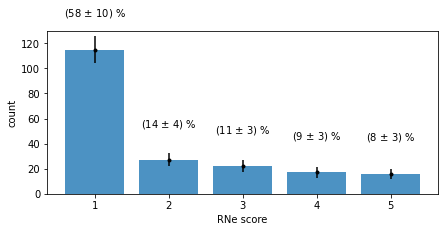

In [6]:
cdf = pd.DataFrame(counts)
cdf['perc'] = cdf['Rne']/cdf['Rne'].sum()
cdf['uncperc'] = cdf['perc']*(np.sqrt(cdf['Rne'])/cdf['Rne'] + np.sqrt(cdf['Rne'].sum())/cdf['Rne'].sum())
ax = plt.bar(range(1,6), counts, alpha=0.8)
labels = [f'({row.perc*100:.0f} $\pm$ {row.uncperc*100:.0f}) %'for i, row in cdf.iterrows()]
plt.bar_label(ax, labels, padding=30, rotation=0, label_type='edge')
plt.errorbar(cdf.index, cdf.Rne, np.sqrt(cdf.Rne), fmt='.', color='black')
plt.ylim(0,130)
plt.ylabel('count')
plt.xlabel('RNe score')
plt.gcf().set_size_inches(7,3)
plt.savefig('images/histscore_dunhmart.png', dpi=500, bbox_inches='tight')

### From which catalogue are the yso associated with RNe?

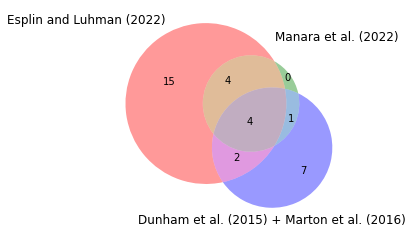

In [7]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import matplotlib

plt.gcf().clear()
# Use the venn2 function
ysorne = yso.loc[rne[rne.Rne>3].index]

def getvenndata(yso):
    a = len(yso[yso.esplin_f & ~yso.dunhmart_f & ~yso.ppvii_f])
    b = len(yso[~yso.esplin_f & ~yso.dunhmart_f & yso.ppvii_f])
    c = len(yso[yso.esplin_f & ~yso.dunhmart_f & yso.ppvii_f])
    d = len(yso[~yso.esplin_f & yso.dunhmart_f & ~yso.ppvii_f])
    e = len(yso[yso.esplin_f & yso.dunhmart_f & ~yso.ppvii_f])
    f = len(yso[~yso.esplin_f & yso.dunhmart_f & yso.ppvii_f])
    g = len(yso[yso.esplin_f & yso.dunhmart_f & yso.ppvii_f])
    return (a, b, c,d,e,f,g)
venn3(subsets = getvenndata(ysorne), set_labels = ('Esplin and Luhman (2022)', 'Manara et al. (2022)\n', 'Dunham et al. (2015) + Marton et al. (2016)'))
plt.savefig('images/vennRNe.png', dpi=500, bbox_inches='tight')

# Frequency of RNe associated to YSO per YSO class

#### Dunham classification

In [53]:
# classify yso in dunhma to SED
for i,ys in tqdm(yso[yso.dunhmart_f].iterrows()):
    if dunhmart.loc[ys.dunhmart_i, 'alpha0'] > 0.3:
        c = 'I'
    elif dunhmart.loc[ys.dunhmart_i, 'alpha0'] >= -0.3:
        c = 'flat spectrum'
    elif dunhmart.loc[ys.dunhmart_i, 'alpha0'] >= -1.6:
        c = 'II'
    elif dunhmart.loc[ys.dunhmart_i, 'alpha0'] < -1.6:
        c = 'III'
        
    yso.loc[i, 'class_duh'] = c
    yso.loc[i, 'alpha0'] = dunhmart.loc[ys.dunhmart_i, 'alpha0']

72it [00:00, 4869.23it/s]


/tmp/ipykernel_20636/2662936162.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  histrne = plt.hist(yso.loc[rne[rne.Rne>3].index][yso.dunhmart_f]['alpha0'], bins=10, label='with RNe', alpha=0.7)


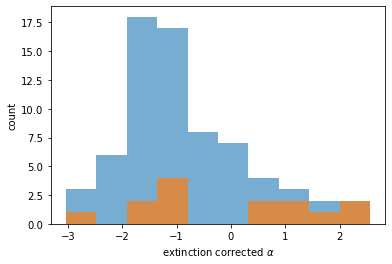

In [9]:
histtotal = plt.hist(yso[yso.dunhmart_f]['alpha0'], bins=10, alpha=0.6, label='all')
histrne = plt.hist(yso.loc[rne[rne.Rne>3].index][yso.dunhmart_f]['alpha0'], bins=10, label='with RNe', alpha=0.7)
plt.xlabel('extinction corrected $\\alpha$')
plt.ylabel('count')
plt.savefig('images/distrwa.pdf', bbox_inches='tight', dpi=500)

In [10]:
unctot = np.sqrt(histtotal[0])
tot = histtotal[0]
wrne = histrne[0]
uncwrne = np.sqrt(wrne)
frac = wrne/tot
x = (histtotal[1][:-1]+histtotal[1][1:])/2
uncfrac = (unctot/tot + uncwrne/wrne )*frac

/tmp/ipykernel_20636/662157542.py:7: RuntimeWarning: invalid value encountered in divide
  uncfrac = (unctot/tot + uncwrne/wrne )*frac


In [11]:
# counting and adding uncertainties
countswrne = yso.loc[ysowrne][yso['class_duh'].notna()]['class_duh'].value_counts()
countswrne['flat spectrum'] = 0
counts = yso['class_duh'].value_counts()
counts = counts.reindex(index = ['I', 'flat spectrum', 'II', 'III'])

#transform in df
countDF = pd.DataFrame(counts)
countDF.rename(columns={'class_duh': 'total'}, inplace=True)
countDF['wrne'] = countswrne

#computing Poisson uncertainties
countDF['unctot'] = np.sqrt(countDF['total'])
countDF['uncwrne'] = np.sqrt(countDF['wrne'])

#computing percentages and unc
countDF['frac'] = countDF['wrne']/countDF['total']
countDF['fracunc'] = (countDF['unctot']/countDF['total'] + countDF['uncwrne']/countDF['wrne'])*countDF['frac']

/tmp/ipykernel_20636/3538760766.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  countswrne = yso.loc[ysowrne][yso['class_duh'].notna()]['class_duh'].value_counts()


In [12]:
countDF

,total,wrne,unctot,uncwrne,frac,fracunc
I,11,7,3.316625,2.645751,0.636364,0.432394
flat spectrum,7,0,2.645751,0.000000,0.000000,NaN
II,36,5,6.000000,2.236068,0.138889,0.085261
III,21,2,4.582576,1.414214,0.095238,0.088126


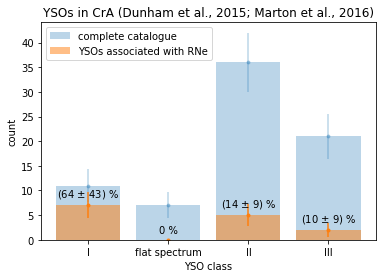

In [13]:
import matplotlib 
plt.clf()
ax = plt.bar(countDF.index, countDF.total, alpha=0.3, label='complete catalogue')
ax2 = plt.bar(countDF.index, countDF.wrne, alpha=0.5, label='YSOs associated with RNe')
labels = [f'({row.frac*100:.0f} $\pm$ {row.fracunc*100:.0f}) %' if i!='flat spectrum' else '0 %' for i, row in countDF.iterrows()]
plt.bar_label(ax2, labels, padding=5, rotation=0)
plt.errorbar(countDF.index, countDF.total, yerr=countDF.unctot, fmt=".", alpha=0.3)
plt.errorbar(countDF.index, countDF.wrne, yerr=countDF.uncwrne, fmt=".", alpha=1)
plt.gcf().set_size_inches(6,4)
plt.legend(loc='upper left')
plt.xlabel('YSO class')
plt.ylabel('count')
plt.title('YSOs in CrA (Dunham et al., 2015; Marton et al., 2016)')
plt.savefig('images/ysoRNefrac.png', bbox_inches='tight', dpi=500)

In [14]:
# plot with I e flat combined
countDF.loc['I', 'total'] = countDF.loc['I', 'total'] + countDF.loc['flat spectrum', 'total']
#computing Poisson uncertainties
countDF['unctot'] = np.sqrt(countDF['total'])
countDF['uncwrne'] = np.sqrt(countDF['wrne'])

#computing percentages and unc
countDF['frac'] = countDF['wrne']/countDF['total']
countDF['fracunc'] = (countDF['unctot']/countDF['total'] + countDF['uncwrne']/countDF['wrne'])*countDF['frac']
countDF.drop(index='flat spectrum', inplace=True)

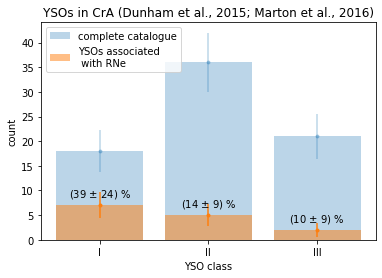

In [15]:
import matplotlib 
ax = plt.bar(countDF.index, countDF.total, alpha=0.3, label='complete catalogue')
ax2 = plt.bar(countDF.index, countDF.wrne, alpha=0.5, label='YSOs associated \n with RNe')
labels = [f'({row.frac*100:.0f} $\pm$ {row.fracunc*100:.0f}) %' if i!='flat spectrum' else '0 %' for i, row in countDF.iterrows()]
plt.bar_label(ax2, labels, padding=5, rotation=0)
plt.errorbar(countDF.index, countDF.total, yerr=countDF.unctot, fmt=".", alpha=0.3)
plt.errorbar(countDF.index, countDF.wrne, yerr=countDF.uncwrne, fmt=".", alpha=1)

plt.legend(loc='upper left')
plt.xlabel('YSO class')
plt.ylabel('count')
plt.title('YSOs in CrA (Dunham et al., 2015; Marton et al., 2016)')
plt.savefig('images/ysoRNefrac.png', bbox_inches='tight', dpi=500)

#### Esplin classification

In [16]:
# classify yso in dunhma to SED
for i,ys in tqdm(yso[yso.esplin_f].iterrows()):
    es_class = esplin.loc[ys.esplin_i, 'DiskType']
    if es_class in ['flat/I']:
        c = 'I'
    elif es_class in ['III']:
        c = 'III'
    else:
        c = 'II'
        
    yso.loc[i, 'class_espl'] = c

395it [00:00, 10498.38it/s]


In [17]:
yso[yso.esplin_f & yso.dunhmart_f]

,index,Unnamed: 0,ra,dec,ppvii_f,esplin_f,dunhmart_f,ppvii_i,esplin_i,dunhmart_i,class_duh,alpha0,class_espl
2,2,2,282.076205,-37.184358,False,True,True,NaN,206.0,116462.0,III,-1.776548,II
3,3,3,285.480202,-37.394744,True,True,True,876.0,345.0,120933.0,II,-0.794506,II
4,4,4,285.188823,-37.196775,True,True,True,847.0,295.0,120934.0,II,-1.320000,II
5,5,5,283.842160,-37.801257,False,True,True,NaN,251.0,120939.0,II,-0.632503,II
6,6,6,284.165616,-37.122448,True,True,True,843.0,257.0,120940.0,II,-1.380000,II
7,7,7,285.357389,-36.988733,True,True,True,866.0,311.0,120961.0,III,-1.630000,II
8,8,8,285.285883,-36.955747,True,True,True,879.0,302.0,120962.0,II,-1.220000,II
9,9,9,285.384726,-36.967605,True,True,True,852.0,315.0,120963.0,III,-1.710000,II
11,11,11,285.297927,-36.759475,True,True,True,874.0,305.0,120965.0,II,-1.442084,II
12,12,12,285.328938,-36.974590,True,True,True,851.0,308.0,120966.0,II,-1.470000,II


In [18]:
# counting and adding uncertainties
countswrne = yso.loc[ysowrne][yso['class_espl'].notna()]['class_espl'].value_counts()
countswrne['flat spectrum'] = 0
counts = yso[yso['class_espl'].notna()]['class_espl'].value_counts()
counts = counts.reindex(index = ['I', 'II', 'III'])

#transform in df
countDF = pd.DataFrame(counts)
countDF.rename(columns={'class_espl': 'total'}, inplace=True)
countDF['wrne'] = countswrne

#computing Poisson uncertainties
countDF['unctot'] = np.sqrt(countDF['total'])
countDF['uncwrne'] = np.sqrt(countDF['wrne'])

#computing percentages and unc
countDF['frac'] = countDF['wrne']/countDF['total']
countDF['fracunc'] = (countDF['unctot']/countDF['total'] + countDF['uncwrne']/countDF['wrne'])*countDF['frac']

/tmp/ipykernel_20636/201371208.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  countswrne = yso.loc[ysowrne][yso['class_espl'].notna()]['class_espl'].value_counts()


In [19]:
countDF.rename({'I': 'I/flat spectrum'}, inplace=True)

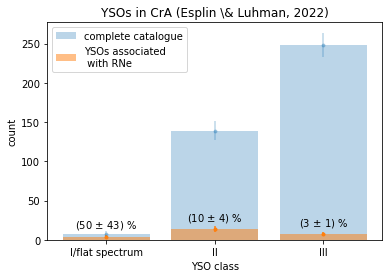

In [20]:
import matplotlib 
plt.clf()


ax = plt.bar(countDF.index, countDF.total, alpha=0.3, label='complete catalogue')
ax2 = plt.bar(countDF.index, countDF.wrne, alpha=0.5, label='YSOs associated \n with RNe')
labels = [f'({row.frac*100:.0f} $\pm$ {row.fracunc*100:.0f}) %' if i!='flat spectrum' else '0 %' for i, row in countDF.iterrows()]
plt.bar_label(ax2, labels, padding=5, rotation=0)
plt.errorbar(countDF.index, countDF.total, yerr=countDF.unctot, fmt=".", alpha=0.3)
plt.errorbar(countDF.index, countDF.wrne, yerr=countDF.uncwrne, fmt=".", alpha=1)
plt.gcf().set_size_inches(6,4)
plt.legend(loc='upper left')
plt.xlabel('YSO class')
plt.ylabel('count')
plt.title('YSOs in CrA (Esplin \& Luhman, 2022)')
plt.savefig('images/ysoRNeesplin.png', bbox_inches='tight', dpi=500)

# Correlation with YSO properties. Manara et al. (2023) catalogue.

Note: xmatched objects are all with class II disks

In [23]:
yso_in_manara = yso[yso.ppvii_f].ppvii_i
ysowrne_in_manara = yso.loc[ysowrne][yso.loc[ysowrne].ppvii_f].ppvii_i
ysoPPVII = ppvii.loc[yso_in_manara]
ysowrnePPVII = ppvii.loc[ysowrne_in_manara]

## M$_\star$ and M$_{\text{dust}}$

data from PPVII table originally from Cazzoletti et al. (2019)

In [24]:
mdustRNE = [0 if ('<' in el)  or (el=='[, ]') else float(el.split(',')[1][:-1]) for el in ysowrnePPVII['Mdust_Mearth_Standardized']]

In [25]:
mdust = np.array([0 if ('<' in el) or (el=='[, ]') else float(el.split(',')[1][:-1]) for el in ysoPPVII['Mdust_Mearth_Standardized']])

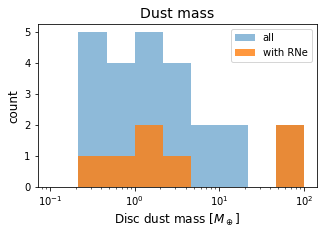

In [27]:
plt.hist(mdust[mdust>0], bins=np.logspace(-1,2,10), alpha=0.5, label='all')
plt.hist(mdustRNE,bins=np.logspace(-1,2,10), alpha=0.8, label='with RNe')
plt.xscale('log')
plt.title('Dust mass', size=14)
plt.xlabel('Disc dust mass [$M_\oplus$]', size=12)
plt.ylabel('count', size=12)
plt.gcf().set_size_inches(5,3)
plt.legend()
plt.savefig('images/dustmass.png', bbox_inches='tight', dpi=500)

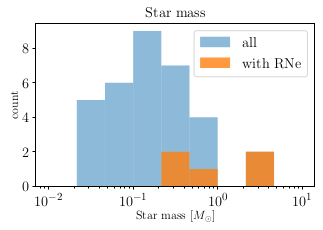

In [90]:
plt.hist(ysoPPVII['Mstar_PPVII'], bins=np.logspace(-2,1,10), alpha=0.5, label='all')
plt.hist(ysowrnePPVII['Mstar_PPVII'],bins=np.logspace(-2,1,10), alpha=0.8, label='with RNe')
plt.xscale('log')
plt.title('Star mass', size=14)
plt.xlabel('Star mass [$M_\odot$]', size=12)
plt.ylabel('count', size=12)
plt.gcf().set_size_inches(5,3)
plt.legend()
plt.savefig('images/starmass.png', dpi=500, bbox_inches='tight')

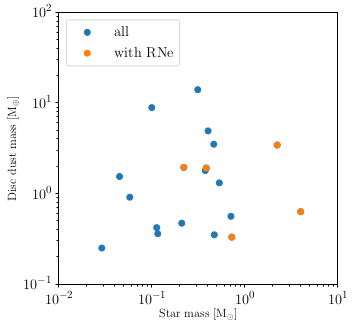

In [91]:
plt.scatter(ysoPPVII['Mstar_PPVII'], mdust, label='all')
plt.scatter(ysowrnePPVII['Mstar_PPVII'], mdustRNE, label='with RNe')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01,10)
plt.ylim(0.1,100)
plt.xlabel('Star mass [M$_\odot$]', size=12)
plt.ylabel('Disc dust mass [M$_\oplus$]', size=12)
plt.legend(loc='upper left')
plt.gcf().set_size_inches(5,5)
plt.savefig('images/scatterplot.png', dpi=500, bbox_inches='tight')

## Star distance

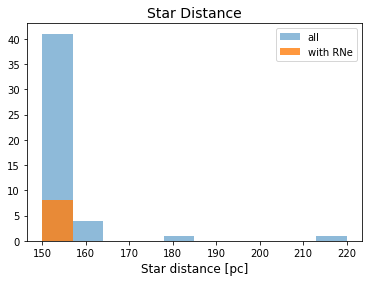

In [81]:
plt.hist(ysoPPVII['EDR3_Dist_PPVII'], bins=10, range=(150, 220), alpha=0.5, label='all')
plt.hist(ysowrnePPVII['EDR3_Dist_PPVII'], bins=10, range=(150, 220), alpha=0.8, label='with RNe')
plt.title('Star Distance', size=14)
plt.xlabel('Star distance [pc]', size=12)
plt.savefig('images/dist1.pdf', dpi=500, bbox_inches='tight')
plt.legend()

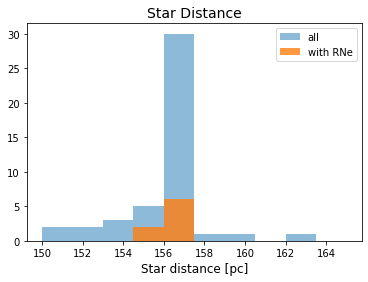

In [82]:
plt.hist(ysoPPVII['EDR3_Dist_PPVII'], bins=10, range=(150, 165), alpha=0.5, label='all')
plt.hist(ysowrnePPVII['EDR3_Dist_PPVII'], bins=10, range=(150, 165), alpha=0.8, label='with RNe')
plt.title('Star Distance', size=14)
plt.xlabel('Star distance [pc]', size=12)
plt.legend()
plt.savefig('images/dist2.pdf', dpi=500, bbox_inches='tight')

# Create catalogue with coordinates


In [7]:
rne = rne[rne.in_data]

In [12]:
withrne = yso[rne.Rne>3]

In [20]:
wrne = withrne.drop(columns=['Unnamed: 0', 'index'])

In [22]:
wrne.to_csv('yso_with_rne.csv')

# Merge all the catalogues

In [56]:
rne = pd.read_csv('catalogue.csv')

In [57]:
rneandyso = rne.join(yso, how='outer')

In [58]:
merged = rneandyso.join(ppvii, on='ppvii_i', how='left', lsuffix='ysorne', rsuffix='ppvii')

In [59]:
merged = merged.join(esplin, on='esplin_i', how='left', rsuffix='esplin')

In [60]:
merged = merged.join(dunhmart, on='dunhmart_i', how='left', rsuffix='dunhmart')

In [67]:
rne

,index,in_data,u,g,r,Ha,i,r.Ha.i,Rne,coherent,shape,best_filter,comment
0,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,True,no,no,no,faint,no,faint,3.0,y,tail,Ha,maybe very faint nebulosity in other filters
4,4,True,no,no,no,no,no,no,1.0,NaN,NaN,NaN,"can’t see the star in the u band, the point at..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,441,True,no,no,no,no,no,no,1.0,NaN,NaN,NaN,NaN
442,442,True,no,no,no,no,no,no,1.0,NaN,NaN,NaN,bright star
443,443,True,no,no,no,no,no,no,1.0,NaN,NaN,NaN,NaN
444,444,True,no,no,no,no,no,no,1.0,NaN,NaN,NaN,NaN


In [64]:
merged[merged.Rne>3][['u', 'g', 'r', 'Ha', 'i', 'r.Ha.i', 'Rne', 'coherent', 'shape', 'best_filter', 'comment''DiskType', 'Disk', 'class_duh'] ]

,DiskType,Disk,class_duh
8,full,II,II
29,full,II,II
31,full,II,II
35,full,II,II
38,NaN,NaN,I
50,flat/I,NaN,I
51,NaN,NaN,I
54,NaN,NaN,II
55,NaN,NaN,I
67,NaN,NaN,I
